## 0. Load Libraries

In [4]:
# Basic Libraries
import numpy as np
import pandas as pd
import re
from collections import Counter

# NLP Libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ngrams

# Ensure required NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Data Preprocessing and Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

# Data Balancing
from imblearn.over_sampling import SMOTE

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Statistical Distributions for Hyperparameter Tuning
from scipy.stats import uniform, randint

# Model Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameter Optimization
from skopt import BayesSearchCV

# Serialization
import pickle

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Text Preprocessing

## 1.0: data info

In [5]:
df = pd.read_csv('data/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## 1.1 Data Preprocessing

## 1.1.1: Text Cleaning and Tokenization:

1. **Remove Special Characters and URLs**: Any URLs and special characters are removed from the text to avoid irrelevant information that could interfere with model predictions.

2. **Convert to Lowercase**: All text is converted to lowercase to maintain uniformity, making it easier to analyze and compare words regardless of their original capitalization.

3. **Remove Stopwords**: Common filler words, such as "a," "an," and "the," which add little value to the meaning of the text, are removed. This reduces noise and focuses the data on more meaningful content.

4. **Tokenization**: The text is broken down into individual words (tokens), allowing us to process each word independently for further analysis.

5. **Lemmatization**: Each word is reduced to its base form. This helps group words with similar meanings (e.g., "running" and "run") and simplifies the text data.

6. **Handle Missing Data**: Any missing entries in the `posts` column are replaced with an empty string to ensure consistency.

In [8]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+|bit\.ly/\S+', '', text, flags=re.MULTILINE)

    # Remove special characters (retain only letters and numbers)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the 'posts' column
df['cleaned_posts'] = df['posts'].apply(lambda x: preprocess_text(str(x)))

# Handle missing data in 'cleaned_posts'
df['cleaned_posts'].fillna('', inplace=True)

# Check the processed data
print(df[['type', 'cleaned_posts']].head())

   type                                      cleaned_posts
0  INFJ  intj moment sportscenter top ten play prankswh...
1  ENTP  im finding lack post alarmingsex boring positi...
2  INTP  good one course say know thats blessing cursed...
3  INTJ  dear intp enjoyed conversation day esoteric ga...
4  ENTJ  youre firedthats another silly misconception a...


/var/folders/yd/0rx8hpn96fd0480f9ndhwn_00000gn/T/ipykernel_51107/2208585870.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_posts'].fillna('', inplace=True)


## 1.1.2: Label Encoding:
- Encodes MBTI types into integers, which is suitable for machine learning algorithms that require numerical labels.
- Saves the mapping for later interpretation.

In [9]:
# Encode MBTI types into integer labels
label_encoder = LabelEncoder()
df['encoded_type'] = label_encoder.fit_transform(df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

## 1.1.3: Data Exploration

### 1.1.3.1: cleans text by removing stopwords and commonb words to retain only the meaningful words for frequency analysis
- Convert the text to lowercase for uniformity.
- Tokenize the text using nltk.word_tokenize to split it into individual words.
- Use a combined stopword list (stopwords + common_words) to remove less meaningful words.
- Retain only alphabetic tokens using isalpha.
- Output: A list of cleaned tokens for further analysis.

In [10]:
def remove_comm_words(text, common_words):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(common_words)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

### 1.1.3.2: extract the top n most common words from the dataset

In [11]:
# Find the 20 most common words for each MBTI type
def get_common_words(df, n=20):
    all_words = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['posts']
        all_posts = ' '.join(mbti_posts)
        words = preprocess_text(all_posts)
        word_freq = Counter(words.split())
        top_words = word_freq.most_common(n)
        all_words[mbti] = [word for word, count in top_words]
    return all_words

common_words_dict = get_common_words(df, n=20)

print('INFJ:',common_words_dict['INFJ'])
print('ENTP:',common_words_dict['ENTP'])
print('INTP:',common_words_dict['INTP'])
print('INTJ:',common_words_dict['INTJ'])
print('ENTJ:',common_words_dict['ENTJ'])
print('ENFJ:',common_words_dict['ENFJ'])
print('INFP:',common_words_dict['INFP'])
print('ENFP:',common_words_dict['ENFP'])
print('ISFP:',common_words_dict['ISFP'])
print('ISTP:',common_words_dict['ISTP'])
print('ISFJ:',common_words_dict['ISFJ'])
print('ISTJ:',common_words_dict['ISTJ'])
print('ESTP:',common_words_dict['ESTP'])
print('ESFP:',common_words_dict['ESFP'])
print('ESTJ:',common_words_dict['ESTJ'])
print('ESFJ:',common_words_dict['ESFJ'])

INFJ: ['like', 'im', 'think', 'dont', 'people', 'know', 'one', 'really', 'thing', 'time', 'would', 'get', 'feel', 'infj', 'ive', 'much', 'type', 'make', 'love', 'say']
ENTP: ['like', 'im', 'think', 'dont', 'people', 'one', 'know', 'get', 'would', 'thing', 'really', 'entp', 'time', 'type', 'make', 'say', 'way', 'ive', 'much', 'see']
INTP: ['like', 'im', 'dont', 'think', 'people', 'one', 'would', 'know', 'thing', 'get', 'time', 'really', 'intp', 'make', 'say', 'much', 'ive', 'way', 'type', 'want']
INTJ: ['like', 'im', 'dont', 'people', 'think', 'one', 'would', 'know', 'time', 'intj', 'thing', 'get', 'really', 'make', 'type', 'say', 'ive', 'want', 'much', 'way']
ENTJ: ['like', 'im', 'dont', 'think', 'people', 'one', 'would', 'get', 'know', 'thing', 'entj', 'type', 'time', 'really', 'make', 'see', 'say', 'want', 'good', 'ive']
ENFJ: ['im', 'like', 'think', 'people', 'dont', 'know', 'really', 'one', 'thing', 'get', 'would', 'feel', 'time', 'enfj', 'friend', 'love', 'ive', 'make', 'much', 's

#### observation
- Many words like 'like', 'im', 'think', and 'dont' are shared across types, indicating general linguistic patterns.
- Specific MBTI-related terms (e.g., 'infj', 'entp') also appear frequently.
- Emotional words like 'love', 'feel', and 'friend' are more common in Feeling types (e.g., ENFJ, INFP).

### 1.1.3.3: Word Cloud - Unigrams

In [12]:
def get_wordCloud_unigrams(df, common_words_dict, n=100):
    mbti_terms = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['cleaned_posts']
        all_posts = ' '.join(mbti_posts)
        comm_words = common_words_dict[mbti]
        tokens = remove_comm_words(all_posts, comm_words)
        term_count = Counter(tokens)
        top_terms = term_count.most_common(n)
        mbti_terms[mbti] = {term: count for term, count in top_terms}
    return mbti_terms

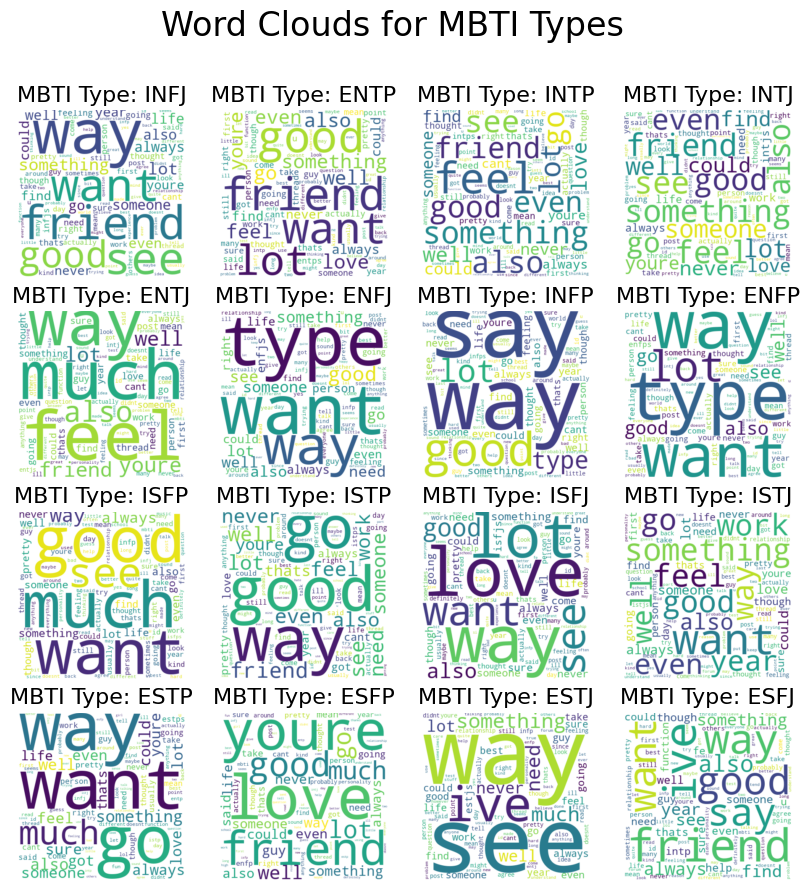

In [13]:
common_words = get_wordCloud_unigrams(df, common_words_dict, n=100)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Word Clouds for MBTI Types', fontsize=24)

axes = axes.flatten()

# Word Cloud
for i, (mbti, words) in enumerate(common_words.items()):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(words)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'MBTI Type: {mbti}', fontsize=16)

plt.show()

#### Observation for Unigrams
1. Common Words Across Types: Words like “way,” “friend,” “want,” and “love” are universally prevalent.


2. **Extroverts vs. Introverts:**
- Extroverts: Action-oriented words (e.g., “go,” “love”) indicating a focus on social activities.
- Introverts: Reflective words (e.g., “see,” “something”) suggesting introspection.
3. **Sensing vs. Intuitive:**
- Sensing: Practical words (e.g., “good,” “much”).
- Intuitive: Abstract words (e.g., “see,” “something”).
4. **Feeling vs. Thinking:**
- Feeling: Emotion and relationship-focused words (e.g., “feel,” “love”).
- Thinking: Work-related words (e.g., “work”).
5. **Judging vs. Perceiving:**
- Judging: Goal-oriented words (e.g., “want,” “way”).
- Perceiving: Spontaneous words (e.g., “go,” “much”).


### 1.1.3.4: Word Cloud - Bigrams

In [14]:
def get_ngrams(tokens, n):
    return [' '.join(ng) for ng in ngrams(tokens, n)]

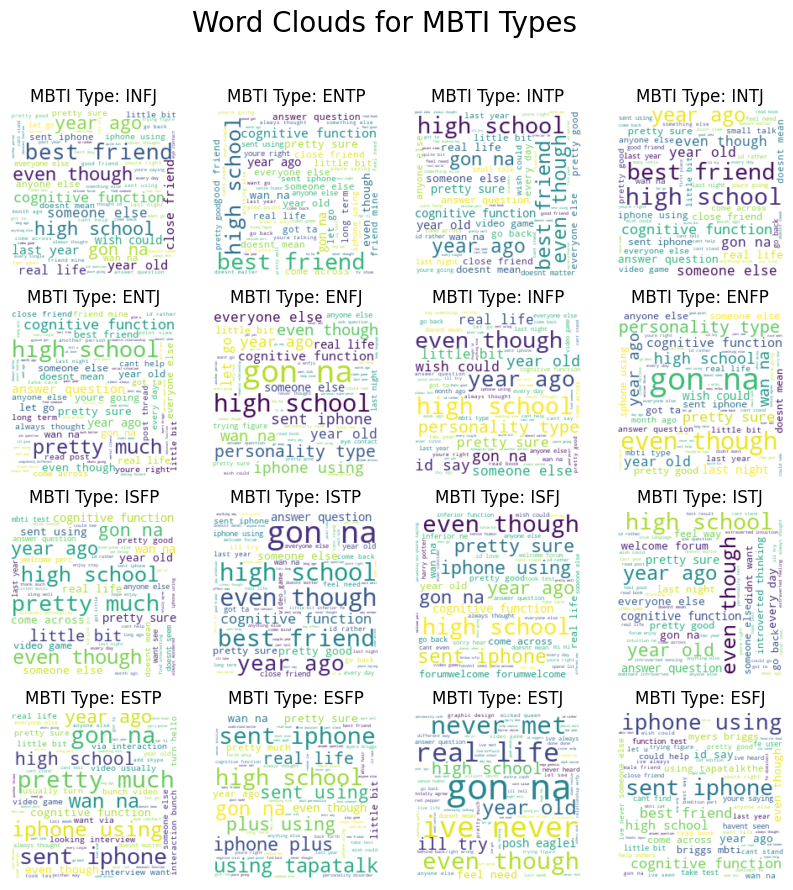

In [15]:
def get_wordCloud_bigrams(df, common_words_dict, n=100):
    mbti_terms = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['cleaned_posts']
        all_posts = ' '.join(mbti_posts)
        comm_words = common_words_dict[mbti]
        tokens = remove_comm_words(all_posts, comm_words)
        bigrams = get_ngrams(tokens, 2)
        term_count = Counter(bigrams)
        top_terms = term_count.most_common(n)
        mbti_terms[mbti] = {term: count for term, count in top_terms}
    return mbti_terms

common_phrase = get_wordCloud_bigrams(df, common_words_dict, n=100)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Word Clouds for MBTI Types', fontsize=20)

axes = axes.flatten()

# Word Cloud
for i, (mbti, words) in enumerate(common_phrase.items()):
    wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(words)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'MBTI Type: {mbti}', fontsize=12)

plt.show()

#### Obervation from Bigrams:
1. Common Phrases Across Types: “High school,” “year ago,” “even though,” “real life,” “best friend,” and “pretty much” dominate, suggesting reflections on past experiences and relationships.

2. **Extroverts vs. Introverts:**
- Extroverts: Future/present-oriented phrases (e.g., “gon na,” “real life”).
- Introverts: Past-oriented phrases (e.g., “high school,” “year ago”).
3. **Sensing vs. Intuitive:**
- Sensing: Real-world interaction phrases (e.g., “real life,” “sent iphone”).
- Intuitive: Less distinct differences observed.
4. **Feeling vs. Thinking:**
- Thinking: Intellectual phrases (e.g., “cognitive function,” “answer question”).
- Feeling: No major distinctions observed.
5. **Judging vs. Perceiving:**
- Judging: Past-focused phrases (e.g., “high school”).
- Perceiving: Future-focused phrases (e.g., “gon na”).

### 1.1.3.5: Sentiment analysis

#### Calculate sentiment scores 

In [16]:
sent_analyser = SentimentIntensityAnalyzer()

# Function to get all sentiment scores
def get_sentiment_scores(text):
    scores = sent_analyser.polarity_scores(text)
    return pd.Series({
        'compound': scores['compound'],
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu']
    })

df[['compound', 'positive', 'negative', 'neutral']] = df['cleaned_posts'].apply(get_sentiment_scores)

# Groups data by MBTI type and calculates the mean positive, negative, and neutral sentiment scores.
avg_scores = df.groupby('type')[['positive', 'negative', 'neutral']].mean()
print("Average Positive, Negative, and Neutral Scores:")
print(avg_scores)

Average Positive, Negative, and Neutral Scores:
      positive  negative   neutral
type                              
ENFJ  0.268437  0.113053  0.618458
ENFP  0.260961  0.112767  0.626239
ENTJ  0.225069  0.120277  0.654641
ENTP  0.223889  0.121232  0.654844
ESFJ  0.251667  0.104381  0.643810
ESFP  0.229604  0.118083  0.652292
ESTJ  0.229000  0.117026  0.653897
ESTP  0.229326  0.119404  0.651303
INFJ  0.240383  0.115988  0.643619
INFP  0.241831  0.121941  0.635678
INTJ  0.218284  0.119985  0.661744
INTP  0.213365  0.123235  0.663414
ISFJ  0.247277  0.111066  0.641639
ISFP  0.245690  0.112915  0.641439
ISTJ  0.223746  0.112951  0.663293
ISTP  0.213389  0.127596  0.659015


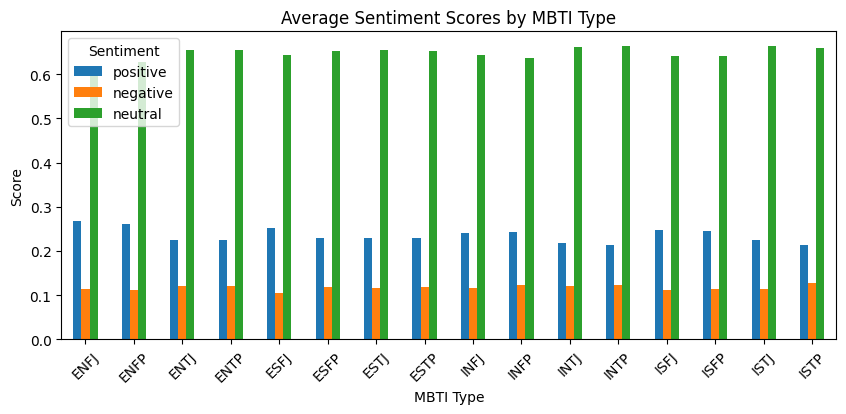

In [17]:
# Bar chart visualization highlights the sentiment tendencies of each MBTI type.
avg_scores.plot(kind='bar', figsize=(10, 4))
plt.title('Average Sentiment Scores by MBTI Type')
plt.xlabel('MBTI Type')
plt.ylabel('Score')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

**Average Sentiment Scores**

1. Positive Sentiment:
- Types like ENFJ, ENFP, and ISFJ exhibit higher positive sentiment.
- Reflects emotional and relationship-oriented traits of Feeling types.
2. Negative Sentiment:
- Types like ISTP and INFP have higher negative sentiment.
- Suggests introspection or reflective tendencies common in Introverted and Thinking types.
3. Neutral Sentiment:
- INTJ and INTP show the highest neutral sentiment, indicating a logical or detached tone in their posts.
- Extroverted types (ESFJ, ENFP) have slightly lower neutrality, likely due to emotional expression.

#### Sentiment Ratio (Positive to Negative)

In [18]:
# Calculates the ratio of positive to negative sentiment (positive / negative) for each MBTI type.
avg_scores['sentiment_ratio'] = avg_scores['positive'] / avg_scores['negative']
print("Sentiment Ratio (Positive to Negative):")
print(avg_scores['sentiment_ratio'].sort_values(ascending=False))

Sentiment Ratio (Positive to Negative):
type
ESFJ    2.411040
ENFJ    2.374441
ENFP    2.314157
ISFJ    2.226393
ISFP    2.175882
INFJ    2.072486
INFP    1.983187
ISTJ    1.980911
ESTJ    1.956836
ESFP    1.944425
ESTP    1.920580
ENTJ    1.871257
ENTP    1.846780
INTJ    1.819257
INTP    1.731372
ISTP    1.672372
Name: sentiment_ratio, dtype: float64


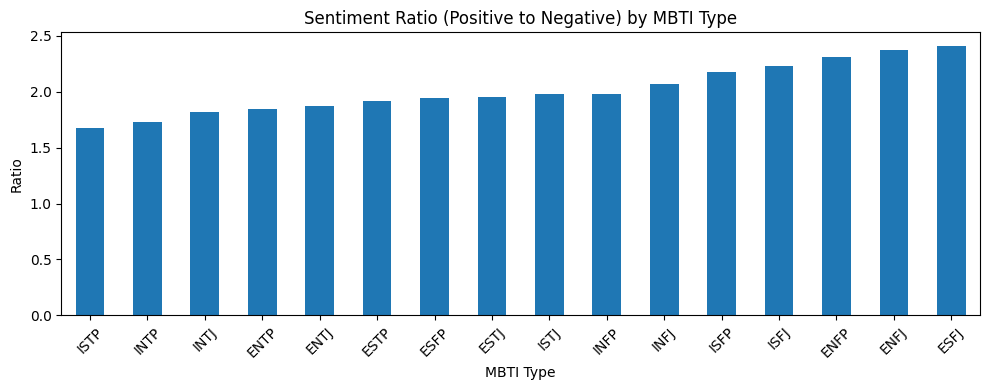

In [19]:
# Bar chart visualization highlights the sentiment tendencies of each MBTI type.
avg_scores['sentiment_ratio'].sort_values().plot(kind='bar', figsize=(10, 4))
plt.title('Sentiment Ratio (Positive to Negative) by MBTI Type')
plt.xlabel('MBTI Type')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Sentiment Ratio**

1. Highest Sentiment Ratio:
- ESFJ, ENFJ, ENFP: Tend to express more positive sentiment compared to negative, aligning with their empathetic and emotionally driven traits.
2. Lowest Sentiment Ratio:
- ISTP, INTP: Exhibit a more balanced or slightly negative tone, consistent with analytical and less emotionally expressive traits.

#### Distribution of Post Length for each Personality Type

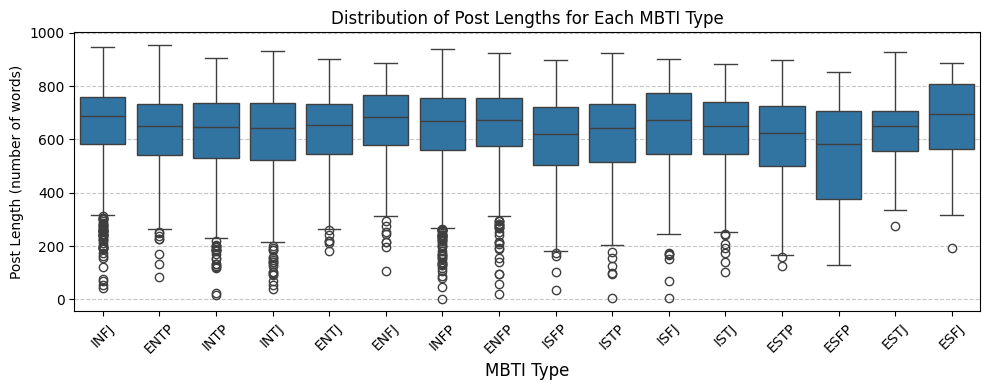

In [20]:
# Func to count words in a post
def count_words(posts):
    return sum(len(post.split()) for post in posts.split('|||'))

df['post_length'] = df['cleaned_posts'].apply(count_words)

plt.figure(figsize=(10, 4))
sns.boxplot(x='type', y='post_length', data=df)

plt.title('Distribution of Post Lengths for Each MBTI Type', fontsize=12)
plt.xlabel('MBTI Type', fontsize=12)
plt.ylabel('Post Length (number of words)', fontsize=10)
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Observation from Distribution
1. **Overall Trend:**
- Most MBTI types write posts averaging 600–700 words.
- The range of word counts is consistent across most types, except for ESFP, which exhibits significantly greater variability.
2. **Longer Posts:**
- Types like ESFJ, ISFJ, and INFJ tend to write longer posts, potentially reflecting their detail-oriented or expressive nature.
3. **Shorter Posts:**
- Types like ESTP and ISTP write shorter posts, aligning with their pragmatic and action-focused tendencies.
4. **Outliers:**
- Certain types, such as INFJ, INTP, INFP, and ENFP, have a wide range of post lengths with noticeable outliers, suggesting that while trends can be generalized, individual differences within each type are significant.

## 1.2: Data Splitting

### 1.2.1: Development-Test Split (80/20):
- Splits the full dataset into a development set (80%) and a test set (20%) using stratified sampling based on MBTI types.
- Maintains class distribution in both sets, as recommended for imbalanced datasets ￼.

In [21]:
# Separate features and target
X = df['cleaned_posts']
y = df['encoded_type']

# Split into Development and Test Sets (80/20 split)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 1.2.2: Training-Validation Split (75/25 of Development Set):
- Further splits the development set into a training set (75%) and a validation set (25%) using stratified sampling.
- This partition allows for hyperparameter tuning on the validation set without affecting the test set, as per class guidelines.

In [22]:
# Split Development Set into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, stratify=y_dev, random_state=42)

### 1.2.3: Class Distribution Check:
- Prints class distribution for each split to confirm successful stratification, ensuring that each subset reflects the original data’s class proportions

In [23]:
print("Data split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Data split sizes:
Training set: 5205 samples
Validation set: 1735 samples
Test set: 1735 samples


In [24]:
y_train.shape

(5205,)

In [25]:
y_val.shape

(1735,)

In [26]:
y_test.shape

(1735,)

In [27]:
# Display the shape of the original splitted data
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5205,)
Validation set shape: (1735,)
Test set shape: (1735,)


- Training Set: 60% of the original data (X_train, y_train).
- Validation Set: 20% of the original data (X_val, y_val).
- Test Set: 20% of the original data (X_test, y_test).

## 1.3: Feature Engineering

### 1.3.1: TF-IDF Vectorization:
- Convert cleaned text into numerical features, using TF-IDF to capture the importance of words relative to each personality type across the dataset. Limit to the top 5000 features for efficiency.

In [28]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

- TFIDF shape

In [29]:
print(f"TF-IDF Training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation set shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test set shape: {X_test_tfidf.shape}")

TF-IDF Training set shape: (5205, 5000)
TF-IDF Validation set shape: (1735, 5000)
TF-IDF Test set shape: (1735, 5000)


### 1.3.2: Elastic Net feature selection and regularization
- Elastic Net to identify and retain the most relevant words for distinguishing between personality types, reducing noise and focusing on important features.

In [30]:
# Initialize Elastic Net with cross-validation
elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=42)

# Use Elastic Net for feature selection on TF-IDF transformed training data
select_model = SelectFromModel(estimator=elastic_net, threshold='mean')

# Fit on training data to determine the selected features
select_model.fit(X_train_tfidf, y_train)

# Transform training, validation, and test data to keep only selected features
X_train_selected = select_model.transform(X_train_tfidf)
X_val_selected = select_model.transform(X_val_tfidf)
X_test_selected = select_model.transform(X_test_tfidf)

- Elastic Net shape

In [31]:
print("Reduced Training set shape:", X_train_selected.shape)
print("Reduced Validation set shape:", X_val_selected.shape)
print("Reduced Test set shape:", X_test_selected.shape)

Reduced Training set shape: (5205, 443)
Reduced Validation set shape: (1735, 443)
Reduced Test set shape: (1735, 443)


### After the TF-IDF vectorization, the current dataset is both sparse and imbalanced

## 1.4: Class Balancing techniques

### 1.4.1: Handling data sparsity with feature selection

- Variance-Based Filtering: Remove features with minimal variance across samples, further refining the feature set.

In [32]:
# Set a variance threshold to filter out low-variance features in Elastic-Net matrix
variance_filter = VarianceThreshold(threshold=0.0001)

# Fit the variance threshold on the balanced training set and transform the training, validation, and test sets
X_train_var = variance_filter.fit_transform(X_train_selected)
X_val_var = variance_filter.transform(X_val_selected)
X_test_var = variance_filter.transform(X_test_selected)

In [33]:
print(f"Variance-Based Training set shape: {X_train_var.shape}")
print(f"Variance-Based Validation set shape: {X_val_var.shape}")
print(f"Variance-Based Test set shape: {X_test_var.shape}")

Variance-Based Training set shape: (5205, 420)
Variance-Based Validation set shape: (1735, 420)
Variance-Based Test set shape: (1735, 420)


### 1.4.2: Handling data imbalance by SMOTE

- Use SMOTE to balance the training dataset across personality types by generating synthetic samples, ensuring that models don’t become biased towards majority classes.

In [34]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_clean, y_train_clean = smote.fit_resample(X_train_var, y_train)

In [35]:
print("Class distribution in the balanced training set:")
print(pd.Series(y_train_clean).value_counts())

Class distribution in the balanced training set:
encoded_type
9     1099
2     1099
8     1099
11    1099
1     1099
10    1099
14    1099
13    1099
3     1099
15    1099
6     1099
12    1099
0     1099
7     1099
4     1099
5     1099
Name: count, dtype: int64


In [36]:
# evaludate the balancing performance on training set to ensure the model is not overfitted.
model = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_clean, y_train_clean, cv=skf, scoring='accuracy')
print(f"Stratified CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Stratified CV Accuracy: 0.8261 ± 0.0058


### Define variables for modeling

- Independent Variable

In [37]:
# Training features
X_train_clean.shape

(17584, 420)

In [38]:
# Validation features
X_val_var.shape

(1735, 420)

In [39]:
# Test Features
X_test_var.shape

(1735, 420)

- Dependent Variable

In [40]:
# Training labels
y_train_clean.shape

(17584,)

In [41]:
# Validation Label
y_val.shape

(1735,)

In [42]:
# Test label
y_test.shape

(1735,)

# 2: Model training

## 2.1: KNN classifier

In [43]:
# Fit the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_clean, y_train_clean)

# Predict using the KNN model
y_pred_knn = knn.predict(X_val_var)

# Calculate metrics
accuracy_knn = accuracy_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn, average='weighted')
precision_knn = precision_score(y_val, y_pred_knn, average='weighted') 
f1_knn = f1_score(y_val, y_pred_knn, average='weighted')

In [44]:
# Display metrics
print(f"KNN Model Accuracy: {accuracy_knn:.6f}")
print(f"KNN Model Recall: {recall_knn:.6f}")
print(f"KNN Model Precision: {precision_knn}")
print(f"KNN Model F1-Score: {f1_knn:.6f}")

KNN Model Accuracy: 0.276081
KNN Model Recall: 0.276081
KNN Model Precision: 0.44225805897791465
KNN Model F1-Score: 0.264920


## 2.2: Decision Tree Classifier

In [45]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_clean, y_train_clean)
y_pred_tree = tree.predict(X_val_var)

accuracy_tree = accuracy_score(y_val, y_pred_tree)
recall_tree = recall_score(y_val, y_pred_tree, average='weighted')    
precision_tree = precision_score(y_val, y_pred_tree, average='weighted')  
f1_tree = f1_score(y_val, y_pred_tree, average='weighted')

In [46]:
# Display metrics
print(f"Accuracy: {accuracy_tree}")
print(f"Recall: {recall_tree}")
print(f"Precision: {precision_tree}")
print(f"F1-Score: {f1_tree}")

Accuracy: 0.41095100864553313
Recall: 0.41095100864553313
Precision: 0.4267240327488418
F1-Score: 0.41677849945384304


## 2.3: Logistic regression

In [47]:
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
log_reg.fit(X_train_clean, y_train_clean)
y_pred_log_reg = log_reg.predict(X_val_var)

accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg, average='weighted')    
precision_log_reg = precision_score(y_val, y_pred_log_reg, average='weighted')
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='weighted')

In [48]:
print(f"Accuracy: {accuracy_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"Precision: {precision_log_reg}")
print(f"F1-Score: {f1_log_reg}")

Accuracy: 0.6051873198847262
Recall: 0.6051873198847262
Precision: 0.6532846163734988
F1-Score: 0.6218659892399386


## 2.4: Random Forest

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_clean, y_train_clean)
y_pred_rf = rf.predict(X_val_var)

accuracy_rf = accuracy_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')   
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  return result


In [50]:
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1-Score: {f1_rf}")

Accuracy: 0.6184438040345821
Recall: 0.6184438040345821
Precision: 0.6116029392879034
F1-Score: 0.611660076108286


## 2.5: XGBoost Model

In [51]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_clean, y_train_clean)
y_pred_xgb = xgb.predict(X_val_var)

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')    
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  return result


In [52]:
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Precision: {precision_xgb}")
print(f"F1-Score: {f1_xgb}")

Accuracy: 0.622478386167147
Recall: 0.622478386167147
Precision: 0.6174150912989701
F1-Score: 0.6128176673490195


## 2.6: Adaboost Classifier

In [53]:
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada.fit(X_train_clean, y_train_clean)
y_pred_ada = ada.predict(X_val_var)

accuracy_ada = accuracy_score(y_val, y_pred_ada)
recall_ada = recall_score(y_val, y_pred_ada, average='weighted')    
precision_ada = precision_score(y_val, y_pred_ada, average='weighted')
f1_ada = f1_score(y_val, y_pred_ada, average='weighted')

In [54]:
print(f"Accuracy: {accuracy_ada}")
print(f"Recall: {recall_ada}")
print(f"Precision: {precision_ada}")
print(f"F1-Score: {f1_ada}")

Accuracy: 0.2899135446685879
Recall: 0.2899135446685879
Precision: 0.304795404208744
F1-Score: 0.2427936862252162


## 2.7: Kernel SVM

In [55]:
kernel_svm = SVC(random_state=42)
kernel_svm.fit(X_train_clean, y_train_clean)
y_pred_kernel_svm = kernel_svm.predict(X_val_var)

accuracy_kernel_svm = accuracy_score(y_val, y_pred_kernel_svm)
recall_kernel_svm = recall_score(y_val, y_pred_kernel_svm, average='weighted')    
precision_kernel_svm = precision_score(y_val, y_pred_kernel_svm, average='weighted')
f1_kernel_svm = f1_score(y_val, y_pred_kernel_svm, average='weighted')

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  return result


In [57]:
print(f"Accuracy: {accuracy_kernel_svm}")
print(f"Recall: {recall_kernel_svm}")
print(f"Precision: {precision_kernel_svm}")
print(f"F1-Score: {f1_kernel_svm}")

Accuracy: 0.622478386167147
Recall: 0.622478386167147
Precision: 0.6178160285837574
F1-Score: 0.6143861752738413


## 2.8: Multi-layer Perceptron

In [58]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_clean, y_train_clean)
y_pred_mlp = mlp.predict(X_val_var)

accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
recall_mlp = recall_score(y_val, y_pred_mlp, average='weighted')    
precision_mlp = precision_score(y_val, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_val, y_pred_mlp, average='weighted')

In [59]:
print(f"Accuracy: {accuracy_mlp}")
print(f"Recall: {recall_mlp}")
print(f"Precision: {precision_mlp}")
print(f"F1-Score: {f1_mlp}")

Accuracy: 0.5244956772334294
Recall: 0.5244956772334294
Precision: 0.52307764331665
F1-Score: 0.5225382641219324


### Observation from modeling

**Models Based on Performance**
- Kernel SVM (Accuracy: 62.25%, F1-Score: 61.44%)
- XGBoost (Accuracy: 62.25%, F1-Score: 61.28%)
- Random Forest (Accuracy: 61.84%, F1-Score: 61.17%)
- Logistic Regression (Accuracy: 60.52%, F1-Score: 62.19%)
- Multi-Layer Perceptron (MLP) (Accuracy: 52.45%, F1-Score: 52.25%)
- Decision Tree (Accuracy: 41.10%, F1-Score: 41.68%)
- AdaBoost (Accuracy: 28.99%, F1-Score: 24.28%)
- KNN (Accuracy: 27.61%, F1-Score: 26.49%)

**Conclusion**
- The **Kernel SVM** stands out as the best-performing models based on both accuracy and F1-score
- we will select the **Kernel SVM**, **XGBoost**, **Random Forest**, and **Logistic Regression** as our final models for further analysis.

# 3. Tuning Parameter

## 3.1: Uninformed learning strategies - Random Search

In [60]:
def hyperparameter_tuning(X_train_clean, y_train_clean):
    param_grids = {
        "kernel_svm": {
            'C': uniform(0.1, 10),
            'gamma': uniform(0.001, 1),
            'kernel': ['linear', 'rbf']
            },
        "xgboost": {
            'learning_rate': uniform(0.01, 0.29),
            'n_estimators': [50, 100, 200, 300],
            'max_depth': randint(3, 8),
            'colsample_bytree': uniform(0.5, 0.5)
            },
        "random_forest": {
            'n_estimators': [100, 200, 300],
            'max_depth': randint(10, 31),
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
            },
        "log_reg": [{
            'C': uniform(0.1, 10),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': [500, 1000, 1500]
            },
            {
            'C': uniform(0.1, 10),
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'max_iter': [500, 1000, 1500]
            }
            ]
}
    
    # Models to tune
    models = {
        "kernel_svm": SVC(random_state=42),
        "xgboost": XGBClassifier(eval_metric='mlogloss', random_state=42),
        "random_forest": RandomForestClassifier(random_state=42),
        "log_reg": LogisticRegression(random_state=42)
    }
    
    # Perform RandomizedSearchCV for each model
    best_models = {}
    results = []

    for model_name, model in models.items():
        print(f"Tuning hyperparameters for {model_name}...")
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter=10,
            scoring='f1_weighted',
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(X_train_clean, y_train_clean)
        
        # Store the best estimator and results
        best_models[model_name] = random_search.best_estimator_
        best_params = random_search.best_params_
        best_score = random_search.best_score_

        # Append results to summary
        results.append({
            "Model": model_name,
            "Best Parameters": best_params,
            "Best F-Score": best_score
        })
        print(f"Best Parameters for {model_name}: {best_params}")
        print(f"Best F-Score for {model_name}: {best_score}\n")
    
    # Create a DataFrame for summary
    results_df = pd.DataFrame(results)
    print("Summary of Hyperparameter Tuning Results:")
    print(results_df)
    return best_models, results_df

In [61]:
best_models, results_df = hyperparameter_tuning(X_train_clean, y_train_clean)

Tuning hyperparameters for kernel_svm...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from vers

[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=rbf; total time= 1.1min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=rbf; total time= 1.1min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=7.896910002727692, gamma=0.597850157946487, kernel=rbf; total time= 1.1min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=linear; total time= 1.3min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=linear; total time= 1.3min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.845401188473625, gamma=0.9517143064099162, kernel=linear; total time= 1.3min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.4370861113902182, gamma=0.14386681792194078, kernel=linear; total time= 1.6min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.4370861113902182, gamma=0.14386681792194078, kernel=linear; total time= 1.6min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=3.4370861113902182, gamma=0.14386681792194078, kernel=linear; total time= 1.6min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.6599452033620266, gamma=0.05908361216819946, kernel=rbf; total time= 3.8min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.6599452033620266, gamma=0.05908361216819946, kernel=rbf; total time= 3.9min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=0.30584494295802445, gamma=0.9709098521619943, kernel=rbf; total time= 3.0min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=0.30584494295802445, gamma=0.9709098521619943, kernel=rbf; total time= 3.0min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.6599452033620266, gamma=0.05908361216819946, kernel=rbf; total time= 3.8min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=0.30584494295802445, gamma=0.9709098521619943, kernel=rbf; total time= 2.8min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.9340450985343383, gamma=0.3052422429595377, kernel=rbf; total time= 2.0min
[CV] END C=1.9340450985343383, gamma=0.3052422429595377, kernel=rbf; total time= 2.0min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.9340450985343383, gamma=0.3052422429595377, kernel=rbf; total time= 2.0min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=9.485527090157502, gamma=0.0017787658410143284, kernel=rbf; total time= 4.6min
[CV] END C=9.485527090157502, gamma=0.0017787658410143284, kernel=rbf; total time= 4.7min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=9.485527090157502, gamma=0.0017787658410143284, kernel=rbf; total time= 4.3min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=6.218528947223795, gamma=0.14049386065204184, kernel=rbf; total time= 1.8min


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=6.218528947223795, gamma=0.14049386065204184, kernel=rbf; total time= 1.8min
[CV] END C=0.17066305219717406, gamma=0.024062425041415758, kernel=linear; total time= 3.4min
[CV] END C=9.83755518841459, gamma=0.23377134043030423, kernel=rbf; total time= 1.2min
[CV] END C=0.17066305219717406, gamma=0.024062425041415758, kernel=linear; total time= 3.2min
[CV] END C=6.218528947223795, gamma=0.14049386065204184, kernel=rbf; total time= 1.5min
[CV] END C=0.17066305219717406, gamma=0.024062425041415758, kernel=linear; total time= 3.0min
[CV] END C=9.83755518841459, gamma=0.23377134043030423, kernel=rbf; total time=  59.1s
[CV] END C=9.83755518841459, gamma=0.23377134043030423, kernel=rbf; total time=  58.1s
Best Parameters for kernel_svm: {'C': 7.896910002727692, 'gamma': 0.597850157946487, 'kernel': 'rbf'}
Best F-Score for kernel_svm: 0.9079149187742969

Tuning hyperparameters for xgboost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.529

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Tryi

[CV] END max_depth=16, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  28.4s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  31.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  33.1s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  34.6s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=28, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  37.5s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=16, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  44.8s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.9s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=16, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  46.5s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.8s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.5s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  15.4s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=28, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  56.8s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  13.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=28, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  34.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  19.9s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  27.0s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.7s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=19, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  21.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  41.3s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=19, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  20.4s
[CV] END max_depth=21, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.4s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Tryi

[CV] END max_depth=19, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  30.5s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=21, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  37.8s
[CV] END max_depth=29, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  10.8s
[CV] END max_depth=29, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  11.3s
[CV] END max_depth=24, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  33.5s
[CV] END max_depth=29, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  13.5s
[CV] END max_depth=21, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  52.1s
[CV] END max_depth=24, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  29.7s
[CV] END max_depth=24, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  32.4s
Best Parameters for random_forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F-Score for random_forest: 0.9209834581858383

Tuning hyperp

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to un

[CV] END C=8.761761457749351, max_iter=1500, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=9.799098521619943, max_iter=1000, penalty=l2, solver=liblinear; total time=   2.4s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=1.9182496720710063, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1.9182496720710063, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1.9182496720710063, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=8.761761457749351, max_iter=1500, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=9.799098521619943, max_iter=1000, penalty=l2, solver=liblinear; total time=   3.3s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=8.761761457749351, max_iter=1500, penalty=l2, solver=liblinear; total time=   3.5s
[CV] END C=0.33062425041415755, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.33062425041415755, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.33062425041415755, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=9.799098521619943, max_iter=1000, penalty=l2, solver=liblinear; total time=   3.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=4.098609717152555, max_iter=1500, penalty=l2, solver=liblinear; total time=   2.1s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=4.098609717152555, max_iter=1500, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END C=7.951759613930136, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=7.951759613930136, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=7.951759613930136, max_iter=1500, penalty=elasticnet, solver=saga; total time=   0.0s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END C=4.098609717152555, max_iter=1500, penalty=l2, solver=liblinear; total time=   3.0s
[CV] END C=8.065429868602328, max_iter=1500, penalty=l1, solver=liblinear; total time=   9.2s
[CV] END C=3.1424224295953773, max_iter=1000, penalty=l1, solver=liblinear; total time=   6.7s
[CV] END C=8.065429868602328, max_iter=1500, penalty=l1, solver=liblinear; total time=   9.5s
[CV] END C=8.065429868602328, max_iter=1500, penalty=l1, solver=liblinear; total time=   9.6s
[CV] END C=3.1424224295953773, max_iter=1000, penalty=l1, solver=liblinear; total time=   6.3s
[CV] END C=3.1424224295953773, max_iter=1000, penalty=l1, solver=liblinear; total time=   6.2s


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacksonz

Best Parameters for log_reg: {'C': 8.065429868602328, 'max_iter': 1500, 'penalty': 'l1', 'solver': 'liblinear'}
Best F-Score for log_reg: 0.8758603205719756

Summary of Hyperparameter Tuning Results:
           Model                                    Best Parameters  \
0     kernel_svm  {'C': 7.896910002727692, 'gamma': 0.5978501579...   
1        xgboost  {'colsample_bytree': 0.8087407548138583, 'lear...   
2  random_forest  {'max_depth': 30, 'min_samples_leaf': 1, 'min_...   
3        log_reg  {'C': 8.065429868602328, 'max_iter': 1500, 'pe...   

   Best F-Score  
0      0.907915  
1      0.898460  
2      0.920983  
3      0.875860  


In [62]:
results_df

,Model,Best Parameters,Best F-Score
0,kernel_svm,"{'C': 7.896910002727692, 'gamma': 0.5978501579...",0.907915
1,xgboost,"{'colsample_bytree': 0.8087407548138583, 'lear...",0.898460
2,random_forest,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_...",0.920983
3,log_reg,"{'C': 8.065429868602328, 'max_iter': 1500, 'pe...",0.875860


In [63]:
best_random_forest = best_models['random_forest']
print(f"Best Random Forest Model: {best_random_forest}")

Best Random Forest Model: RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200,
                       random_state=42)


### Random Search CV Results
1. **Random Forest:**
- Achieved the highest F-1 score (92.10%).
2. Kernel SVM:
- Delivered strong performance with F-1 score of 90.8%.
3. XGBoost:
- Achieved 89.84% F-1 score, leveraging tree depth (max_depth=6) and learning rate (0.24) for balanced exploration and exploitation.
4. Logistic Regression:
- Competitive F-1 score (87.59%) with l1 regularization and a high regularization strength (C=8.07).

### Best Model Results
- Best Cross-Validation F-1 score: 92.10%

## 3.2: Informed learning strategy - Bayesian optimization

- Based on the best tuning perfromance by RandomSearchCV, we will use Bayesian optimization to further improve the performance of the model regarding to **max_depth=30, min_samples_split=5, and n_estimators=200**

In [ ]:
import numpy as np
for name, val in {"int": int, "float": float, "bool": bool}.items():
    if not hasattr(np, name):
        setattr(np, name, val)
        
# Define the refined parameter space based on the best model
param_space = {
    'n_estimators': (150, 300),  # Refine around 200
    'max_depth': (25, 35),  # Refine around 30
    'min_samples_split': (2, 10),  # Refine around 5
    'min_samples_leaf': (1, 5)  # Add exploration for leaf sizes
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Bayesian Optimization with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the Bayesian Optimization on the training data
bayes_search.fit(X_train_clean, y_train_clean)

# Extract the best parameters and best score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print("Best Parameters from Bayesian Optimization:", best_params)

print("Best F-Score from Bayesian Optimization:", best_score)

#### Hyperparameter tuning report

After we identified the best hyperparameters by RandomSearchCV, we further leveraged the Bayesian Optimization to further improve the hyperparameters for Random Forest Model. 
1. Improvement Over Previous Tuning:
- The model’s F-1 score improved from 92.20% (Random Search) to 92.64% (Bayesian Optimization).

2. The best set of hyperparameters are:
- max_depth' = 31
- min_samples_leaf = 1,
- min_samples_split = 2
- n_estimators = 300

3. Deploy to the Test Set:
- the best set of hyperparameters were used to train the Random Forest model on the entire dataset and predict the test set labels.

## 3.3: Use best tunned parameter to test whole labels

In [ ]:
# Initialize Random Forest with the best hyperparameters
best_rf = RandomForestClassifier(
    max_depth=31,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

# Fit the model on the training data
best_rf.fit(X_train_clean, y_train_clean)

# Make predictions on the validation or test data
y_pred = best_rf.predict(X_test_var)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6380
Precision: 0.6265
Recall: 0.6380
F1-Score: 0.6297


/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prediction performance on test set
- By applying the best set of hyperparameters, the random forest model achieved an accuracy of **64%** and F-1 of **63%** on the test set.
- The result is improved from *61.84% on accuracy and 61.17% on F1-score* to **63.80% on accuracy and 63.0% on F1-score.**
- The trained and fine-tuned model achieved the highest accuracy and F1-score among all the models selected and trained.